In [118]:
from sklearn.datasets import load_boston
import numpy as np
import pandas as pd

#Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

#To plot the graph embedded in the notebook
%matplotlib inline
boston = load_boston()
np.delete(boston.feature_names,1)
#print(boston.DESCR)
bos = pd.DataFrame(boston.data, columns = boston.feature_names)

bos['PRICE'] = boston.target
#print(bos.describe())
#print(bos.columns)
bos.head()

#Columns 7 and 8, DIS and RAD
boston.feature_names = np.delete(boston.feature_names,7)
boston.feature_names = np.delete(boston.feature_names,7)

boston.data = np.delete(boston.data,7, axis=1)
boston.data = np.delete(boston.data,7, axis=1)

#print(boston.feature_names)
#pd.DataFrame(boston.data).head(10)


So we have 14 variables and we will now examine the correlation matrix. From this matrix, you will already see a number of high correlations >0.7. This tells us that we are likely to have issues.

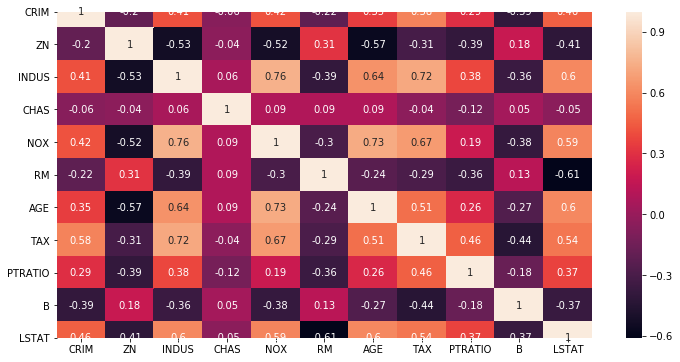

In [119]:
bos_1 = pd.DataFrame(boston.data, columns = boston.feature_names)

correlation_matrix = bos_1.corr().round(2)
plt.figure(figsize=(12, 6))
sns.heatmap(data=correlation_matrix, annot=True)


The next piece of code is not really necessary but you may want to run it for each variable to determine if there is a direct linear relationship with price.

<Figure size 1440x360 with 0 Axes>

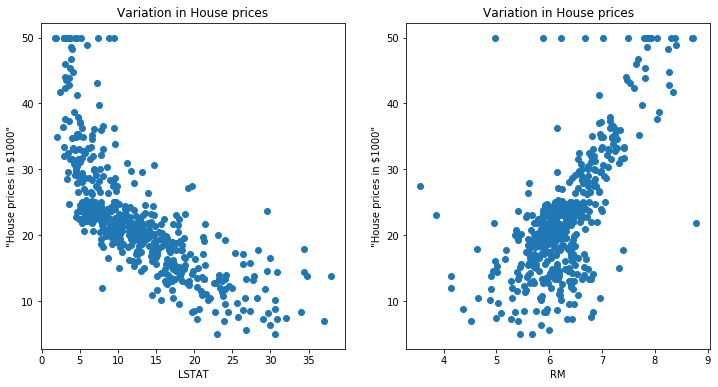

In [120]:
plt.figure(figsize=(20, 5))
#features=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX','PTRATIO', 'B', 'LSTAT']
features = ['LSTAT', 'RM']
target = bos['PRICE']
plt.figure(figsize=(12, 6))
for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = bos[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title("Variation in House prices")
    plt.xlabel(col)
    plt.ylabel('"House prices in $1000"')

Now, this is the important part which we didn't show in M1.3.12. When you run your model in python it gives 2 small warnings at the bottom of the summary. Don't worry about [1] but
\[2\] tells us that the inverted $X^tX$ matrix is close to non-invertible. This is telling us that there is possible multicollinearity in our data. The condition number is the ratio of the largest eigenvalue to the smallest eigenvalue in the $X^TX$(design matrix) matrix. Now, this eigenvalue ratio may also be high because of scaling differences in our design matrix. So we will have to calculate the VIF's for each variable before we can decide what to do next.

In [121]:
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

X=bos[boston.feature_names]
# Use the next line if you want to drop DIS and RAD
#X= X[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE' , 'TAX', 'PTRATIO','B', 'LSTAT']]

y=bos['PRICE']
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size = 0.2, random_state=5)


X = sm.add_constant(X_train_1)

model = sm.OLS(np.log(y_train_1),X)
results = model.fit()
y_pred=results.predict(X)

rms = np.sqrt(mean_squared_error(y_train_1, y_pred))
#

X_test = sm.add_constant(X_test_1)
y_test_pred=results.predict(X_test)
rms_test = np.sqrt(mean_squared_error(y_test_1, y_test_pred))

print("training root mean Square error is: ",rms)
print("test root mean Square error is: ",rms_test)
print(results.summary())

training root mean Square error is:  21.56569188046994
test root mean Square error is:  20.903490551213647
                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     118.7
Date:                Wed, 04 Mar 2020   Prob (F-statistic):          2.33e-117
Time:                        23:03:45   Log-Likelihood:                 82.965
No. Observations:                 404   AIC:                            -141.9
Df Residuals:                     392   BIC:                            -93.91
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------

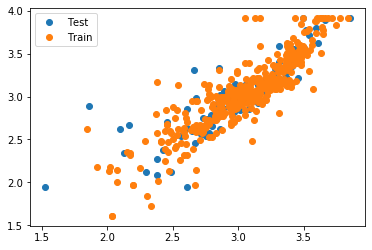

In [122]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(y_test_pred, np.log(y_test_1), 'o', label="Test")
ax.plot(y_pred, np.log(y_train_1), 'o', label="Train")


ax.legend(loc="best");

In [123]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from statsmodels.api import add_constant
import pandas as pd



X = add_constant(X_train_1)

vif = [variance_inflation_factor(X.to_numpy(), i) for i in range(X.to_numpy().shape[1])]
print(vif[1:])

print("VIF > 5:",X.columns[np.where(np.asarray(vif[1:])>5)])


[1.6006084983630726, 1.9887682389566905, 3.6511721399226675, 1.08284097571917, 4.169527799215834, 1.7733272908610311, 2.6479310818500403, 3.594394887451315, 1.7440097604102995, 1.3058789554883197, 2.8414316233596897]
VIF > 5: Index([], dtype='object')


Now the code above is used to find the variables that are affected by multicollinearity. They are the DIS (weighted distances to five Boston employment centres) and the RAD (index of accessibility to radial highways) variables. Now if we remove these variable you will see the condition number is lower but still high, however, the VIFs are all fine. This high condition number is purely a scaling issue as the Multicollinearity is now gone. The literature tells that a condition number above 20 is high. However, this can be caused by variables coming from differing scales as well as multicollinearity.

I would now like you to experiment with the variables in this model and see what happens when you reduce them further. What happens your predictions? Are you concerned about the low values of the Y variable? And can you explain why we have put a log value around Y?